In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
import glob
import scipy.io
import torch
from sklearn.metrics import confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import pickle
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import cv2
import matplotlib.pyplot as plt
from numpy import zeros, newaxis

In [11]:
file = open('/content/drive/MyDrive/CAPSTONE/Aerocity/train_inp','rb')
final_inp = pickle.load(file)
print(len(final_inp))

file = open('/content/drive/MyDrive/CAPSTONE/Aerocity/train_rgb','rb')
final_semantic = pickle.load(file)
print(len(final_semantic))

file = open("/content/drive/MyDrive/CAPSTONE/Aerocity/train_gt",'rb')
final_gt = pickle.load(file)
print(len(final_gt))

2975
2975
2975


In [12]:
class USegNet_residual_dense(nn.Module):  
    def __init__(self):
        super(USegNet_residual_dense, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)

        self.unpool3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)

        self.deconv3_1 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.Conv2d(64, 5, kernel_size = 3, stride = 1, padding = 1)

        # self.skip = torch.cat((first_tensor, second_tensor), 0)


        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.conv_end = nn.Conv2d(in_channels=1, out_channels=5, kernel_size = 1, stride = 1, padding = 0)
        # self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        input=x
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x=x+input # ;+' is residual
        y1=x
        x, idxs1 = self.pool1(x)
        # print ("hello",idxs1)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        input=x
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x=x+input 
        y2=x
        x, idxs2 = self.pool2(x)
       
        # print ("hi",idxs2)
        
        size_3 = x.size()
        
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        input=x
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x=x+input
        y3=x
        x, idxs3 = self.pool3(x)
       

        x = self.unpool3(x, idxs3, output_size = size_3) #upsampling
        x+=y3
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.unpool2(x, idxs2, output_size = size_2)
        x=x+y2
        x= torch.cat((x,y2),1)

        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.unpool1(x, idxs1, output_size = size_1)

        # print (x.shape)
        # print(y.shape)
        x=x+y1
        x= torch.cat((x,y1),1)
       
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x =F.softmax(self.deconv1_2(x)) #within a block residual, acroos a block 

        return x

In [13]:
##VALIDATION
model=USegNet_residual_dense()
checkpoint_file='/content/drive/MyDrive/CAPSTONE/Result_Full/USegNet_residual_dense/checkpoint.pth'
checkpoint = torch.load(checkpoint_file)
model.load_state_dict(checkpoint['model_state_dict'])
img = np.array(final_inp[0:12])
img= np.moveaxis(img, 2, -1)
img= np.moveaxis(img, 2, 1)
img = torch.from_numpy(img)
img = img.type(torch.FloatTensor)
output = model(img)
output = output.view( -1)
output = output.cpu()
output = output.detach().numpy()
 
label_endo = np.array(final_gt[0:8])
label_endo=np.moveaxis(label_endo,2,-1)
label_endo=np.moveaxis(label_endo,2,1)

print(output.shape)
label_endo = label_endo.reshape(8*5*128*256)
prediction = []
for x in output:
  if x>=0.5:
    # print(x)
    prediction.append(1)
  else:
    prediction.append(0)


la=np.array(prediction)
la= np.reshape(la,(int(len(la)/(128*256*5)),5,128,256))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(1966080,)


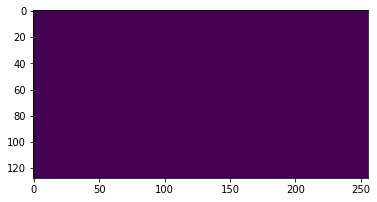

In [14]:
label_endo = np.array(final_gt[0:12])
label_endo=np.moveaxis(label_endo,2,-1)
label_endo=np.moveaxis(label_endo,2,1)
plt.imshow(label_endo[0][2])

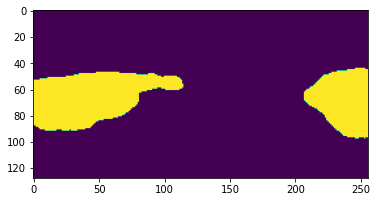

In [15]:
gray = la[3][0]
cvuint8 = cv2.convertScaleAbs(gray)
blur = cv2.blur(cvuint8, (3, 3)) # blur the image
ret,thresh = cv2.threshold(blur,100,255,cv2.THRESH_TOZERO_INV)
imgplot = plt.imshow(thresh)
plt.show()
contours=[]
contours, hierarchy = cv2.findContours(cvuint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
hull = []
for i in range(len(contours)):
  if cv2.contourArea(contours[i])>100:
    # creating convex hull object for each contour
    hull.append(cv2.convexHull(contours[i], False))

In [16]:
image=final_inp[3].copy()
for (i,c) in enumerate(hull):
    M= cv2.moments(c)
    cx= int(M['m10']/M['m00'])
    cy= int(M['m01']/M['m00'])
    font = cv2.FONT_HERSHEY_SIMPLEX
  
    # org
    org = (cx, cy)
      
    # fontScale
    fontScale = 0.3
      
    # Blue color in BGR
    color = (255, 255, 255)
    col=(255,255,255)
    
    # Line thickness of 2 px
    thickness = 1
      
    # Using cv2.putText() method
    image=cv2.drawContours(image, hull, i, col, 1, 8)
    image = cv2.putText(image, 'Car', org, font, 
                      fontScale, color, thickness, cv2.LINE_AA)

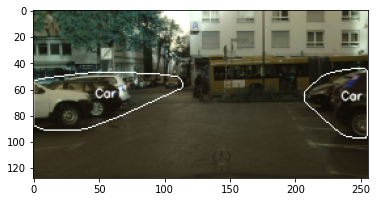

In [17]:
plt.imshow(image)